In [1]:
# import logging
# from ts_piggies.data.pdf import PDF2TextParser
# from ts_piggies.data.extract import PorkColombiaPDFExtractor
# import os
# from ts_piggies.data.downloader import DirectoryDownloader
# from datetime import datetime
# from ts_piggies.data.timetable import PorkColombiaTimetable

# logger = logging.getLogger("ts_piggies")
# logger.setLevel(logging.DEBUG)
# formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# handler = logging.StreamHandler()
# handler.setFormatter(formatter)
# logger.addHandler(handler)


# downloader = DirectoryDownloader(
#     output_path=os.path.join(os.path.dirname("."), ".data", "raw"),
#     timeout=60,
#     num_threads=5,
#     sleep_time=2,
# )

# # path = pdfs.result[0]
# # path = ".data/raw/Informe_Pork_Colombia_Ronda52.pdf"
# timetable = PorkColombiaTimetable(start_date=datetime(2023, 1, 1), end_date=datetime(2023, 12, 31))
# pdf = PDF2TextParser(method="auto")
# extractor = PorkColombiaPDFExtractor(parser=pdf, downloader=downloader, overwrite="FILE")
# extractor.run(*timetable.urls)
# data = extractor.result
# data

In [2]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd

raw_data = pd.read_excel(
    "/Users/drest/Downloads/Book2.xlsx",
    sheet_name="Sheet1",
)

# Unpivot the DataFrame so each year/month is a row, not a column
raw_data = raw_data.melt(id_vars=["Unnamed: 0"], var_name="year", value_name="value")
raw_data = raw_data.rename(columns={"Unnamed: 0": "month"})

raw_data["eom"] = pd.to_datetime(raw_data["year"].astype(str) + "-" + raw_data["month"].astype(str).str.strip() + "-01", format="%Y-%b-%d") + MonthEnd(0)
raw_data.drop(columns=["year", "month"], inplace=True)
weekly_data = pd.read_parquet(".data/extracted/porkcolombia.parquet.snappy")
weekly_data = weekly_data.loc[weekly_data["ts"] >= pd.to_datetime("2023-12-31")]
weekly_data["eom"] = weekly_data["ts"] + MonthEnd(0)
weekly_data_ = weekly_data.groupby("eom").agg({"average": "mean"}).reset_index().sort_values("eom", ascending=False)
combined = raw_data.merge(weekly_data_, on="eom", how="left")
combined["price"] = combined[["value", "average"]].mean(axis=1, skipna=True)
combined.drop(columns=["value", "average"], inplace=True)
combined.sort_values("eom", ascending=False, inplace=True)
# combined.reset_index(drop=True).to_parquet(".data/extracted/porkcolombia_combined.parquet.snappy", index=False)

# combined = combined.loc[combined["eom"] > "2015-01-01"].reset_index(drop=True)
combined


,eom,price
191,2025-12-31,8057.250000
190,2025-11-30,8019.942125
189,2025-10-31,8013.058700
188,2025-09-30,8319.340375
187,2025-08-31,8451.582625
...,...,...
4,2010-05-31,4176.900000
3,2010-04-30,4501.820000
2,2010-03-31,4659.830000
1,2010-02-28,4770.690000


In [3]:
# Using PyTorch Forecasting and Temporal Fusion Transformer for forecasting next 12 months

import torch
from lightning.pytorch import Trainer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer

combined_tft = combined.copy()
# Set up parameters
max_prediction_length = 12  # Forecast next 6 months
max_encoder_length = min(36, len(combined_tft))  # Use up to 3 years of history, or all data if less
batch_size = 64  # Increased batch size for more stable gradients

# Add a group column (only one series, so fill with 'series_1')
# combined = combined.reset_index(drop=True)
combined_tft["series_id"] = "series_1"

# Sort by eom to ensure proper ordering
combined_tft = combined_tft.sort_values("eom", ascending=False).reset_index(drop=True)

# Create integer time index (required by TimeSeriesDataSet)
combined_tft["time_idx"] = range(len(combined_tft))

# Extract datetime features for use as time-varying known reals
combined_tft["year"] = combined_tft["eom"].dt.year
combined_tft["month"] = combined_tft["eom"].dt.month

# TFT expects sequence data with known/observed features split
training_cutoff = combined_tft["eom"].max()  # last date in observed data

# Setup TimeSeriesDataSet
training = TimeSeriesDataSet(
    combined_tft,
    time_idx="time_idx",  # Use integer time index
    target="price",
    group_ids=["series_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["series_id"],
    time_varying_known_reals=["year", "month"],  # Use datetime features as known reals
    time_varying_unknown_reals=["price"],
    target_normalizer=GroupNormalizer(groups=["series_id"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Dataloaders for training and prediction
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

# Create the model with optimized hyperparameters
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,  # Slightly higher learning rate for faster convergence
    hidden_size=64,  # Increased from 32 to 64 for more model capacity
    attention_head_size=4,  # Increased from 1 to 4 for better attention mechanism
    dropout=0.15,  # Slightly increased dropout for better regularization
    hidden_continuous_size=16,  # Increased from 8 to 16 for continuous features
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=6,  # Increased patience for learning rate reduction
)

# Train model with optimized training parameters
trainer = Trainer(
    max_epochs=300,  # Increased epochs for better convergence
    gradient_clip_val=0.15,  # Gradient clipping for stability
    enable_model_summary=False,
    logger=False,
    enable_checkpointing=False,
    accelerator="auto",  # Auto-detect GPU/CPU
)
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
)

# Prepare data for prediction
# Build the prediction/forecast dataframe
import numpy as np
last_eom = combined_tft["eom"].max()
last_time_idx = combined_tft["time_idx"].max()
future_eoms = pd.date_range(last_eom + pd.offsets.MonthEnd(1), periods=max_prediction_length, freq="M")
prediction_data = pd.DataFrame({
    "eom": future_eoms,
    "series_id": "series_1",
})

# Extract datetime features for future dates
prediction_data["year"] = prediction_data["eom"].dt.year
prediction_data["month"] = prediction_data["eom"].dt.month

# Create time_idx for future dates (continuing from last time_idx)
prediction_data["time_idx"] = range(last_time_idx + 1, last_time_idx + 1 + len(prediction_data))

# TFT expects all history plus future
# Build dataframe with all combined_tft data and the future placeholders (price as nan)
model_input = pd.concat([combined_tft[["eom", "price", "series_id", "time_idx", "year", "month"]], prediction_data], ignore_index=True, sort=False)
model_input["price"] = model_input["price"].astype(float)

# Fill NaN values in price for future dates with a placeholder (0 is fine, model will predict anyway)
# Get the last known price to use as placeholder
last_known_price = combined_tft["price"].iloc[-1]
model_input["price"] = model_input["price"].fillna(last_known_price)

# Build TimeSeriesDataSet for prediction
prediction_dataset = TimeSeriesDataSet(
    model_input,
    time_idx="time_idx",  # Use integer time index
    target="price",
    group_ids=["series_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["series_id"],
    time_varying_known_reals=["year", "month"],  # Use datetime features as known reals
    time_varying_unknown_reals=["price"],
    target_normalizer=GroupNormalizer(groups=["series_id"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

predict_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

# Make predictions for the next 12 months
result = tft.predict(predict_dataloader, mode="raw", return_x=True)

raw_predictions = result[0]

# Extract last 12 predictions (future)
# Identify forecast dates by time_idx (future dates have time_idx > last_time_idx)
forecast_index = model_input["time_idx"] > last_time_idx
predicted_dates = model_input.loc[forecast_index, "eom"].values

# Get predicted median (0.5 quantile)
forecast = raw_predictions["prediction"].detach().cpu().numpy()[0, -max_prediction_length:, 3]  # index 3 is 0.5 quantile
forecast_tft_df = pd.DataFrame({"eom": predicted_dates, "forecast": forecast})

# Show forecasted values
forecast_tft_df.set_index("eom")


/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/pytorch_forecasting/models/base/_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, train_loss_step=996.0, train_loss_epoch=1.44e+3] 

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s, train_loss_step=43.80, train_loss_epoch=51.70]  

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s, train_loss_step=43.80, train_loss_epoch=51.70]


/var/folders/x_/bhh5_n9161l5y7xp2k8l1crm0000gp/T/ipykernel_11355/3670467231.py:86: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_eoms = pd.date_range(last_eom + pd.offsets.MonthEnd(1), periods=max_prediction_length, freq="M")
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default 

,forecast
eom,
2026-01-31,10490.754883
2026-02-28,9957.369141
2026-03-31,9585.802734
2026-04-30,9333.914062
2026-05-31,8911.036133
2026-06-30,8503.738281
2026-07-31,8047.619629
2026-08-31,7723.139160
2026-09-30,7435.106445


In [4]:

# Forecasting with N-Beats for the next 12 months using PyTorch Forecasting

from pytorch_forecasting.models import NBeats
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Prepare data for N-Beats (create a copy with required columns)
# N-Beats doesn't support group_ids or categoricals, so we'll use a single series approach
combined_nbeats = combined.copy()
combined_nbeats = combined_nbeats.sort_values("eom").reset_index(drop=True)
combined_nbeats["time_idx"] = range(len(combined_nbeats))

# Keep only the columns needed for N-Beats dataset (time_idx, target)
# N-Beats requires group_ids but they create categoricals
# Use numeric group_id and ensure it's explicitly numeric type
combined_nbeats["group_id"] = 0
combined_nbeats["group_id"] = combined_nbeats["group_id"].astype(int)  # Explicitly numeric
nbeats_data_for_training = combined_nbeats[["time_idx", "price", "group_id"]].copy()

# Prepare sequence parameters (same as for TFT)
nbeats_encoder_length = max_encoder_length
nbeats_prediction_length = max_prediction_length

# Build the dataset for NBeats - minimal configuration
# N-Beats only accepts the target variable, no other features
training_cutoff = nbeats_data_for_training["time_idx"].max() - nbeats_prediction_length

# Apply MinMaxScaler to the price column
# Fit scaler on training data only
train_data_for_scaling = nbeats_data_for_training[nbeats_data_for_training.time_idx <= training_cutoff]
nbeats_scaler = MinMaxScaler()
nbeats_scaler.fit(train_data_for_scaling[["price"]])

# Transform all price data
nbeats_data_for_training["price_scaled"] = nbeats_scaler.transform(nbeats_data_for_training[["price"]])
# Use scaled price for the dataset
nbeats_data_for_training_scaled = nbeats_data_for_training[["time_idx", "price_scaled", "group_id"]].copy()
nbeats_data_for_training_scaled = nbeats_data_for_training_scaled.rename(columns={"price_scaled": "price"})

# N-Beats requires minimal configuration - only target variable
# group_ids are required by TimeSeriesDataSet but create categoricals
# We'll use numeric group_id and hope N-Beats can handle it
# Use scaled data for training
nbeats_training = TimeSeriesDataSet(
    nbeats_data_for_training_scaled[nbeats_data_for_training_scaled.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="price",
    group_ids=["group_id"],  # Required by TimeSeriesDataSet (creates categorical, but N-Beats checks this)
    min_encoder_length=nbeats_encoder_length,
    max_encoder_length=nbeats_encoder_length,
    min_prediction_length=nbeats_prediction_length,
    max_prediction_length=nbeats_prediction_length,
    # N-Beats ONLY accepts target in time_varying_unknown_reals, nothing else
    time_varying_unknown_reals=["price"],
    # Don't specify static_categoricals or static_reals - let TimeSeriesDataSet handle group_ids
    # Use no normalizer since we've already applied MinMaxScaler
    target_normalizer=None,
    add_relative_time_idx=False,
    add_target_scales=False,
    add_encoder_length=False,
)

nbeats_train_dataloader = nbeats_training.to_dataloader(train=True, batch_size=32, num_workers=0)

# Validation set for NBeats (last max_prediction_length points)
# Use scaled data for validation
nbeats_validation = TimeSeriesDataSet.from_dataset(nbeats_training, nbeats_data_for_training_scaled, predict=True, stop_randomization=True)
nbeats_val_dataloader = nbeats_validation.to_dataloader(train=False, batch_size=16, num_workers=0)

# Fit NBeats model
nbeats_model = NBeats.from_dataset(
    nbeats_training,
    learning_rate=0.015,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=(256, 1024),
    backcast_loss_ratio=0.1,
    stack_types=["trend"],
)


# Use the same Trainer import as TFT
nbeats_trainer = Trainer(
    max_epochs=200,
    gradient_clip_val=0.05,
    enable_model_summary=True,
    enable_checkpointing=False,
    logger=False,
    enable_progress_bar=False,
    accelerator="auto",
)

nbeats_trainer.fit(
    nbeats_model,
    train_dataloaders=nbeats_train_dataloader,
    val_dataloaders=nbeats_val_dataloader,
)

# Prepare prediction data for N-Beats (need to extend with future dates)
last_eom_nbeats = combined_nbeats["eom"].max()
last_time_idx_nbeats = nbeats_data_for_training_scaled["time_idx"].max()
future_eoms_nbeats = pd.date_range(last_eom_nbeats + pd.offsets.MonthEnd(1), periods=nbeats_prediction_length, freq="M")

# Create prediction DataFrame with proper structure (need index for scalar values)
# Use scaled price for prediction data
last_scaled_price = nbeats_data_for_training_scaled["price"].iloc[-1]
nbeats_prediction_data_df = pd.DataFrame({
    "group_id": [0] * nbeats_prediction_length,  # Use numeric group_id, repeat for each prediction
    "price": [last_scaled_price] * nbeats_prediction_length,  # Placeholder price (scaled)
    "time_idx": range(last_time_idx_nbeats + 1, last_time_idx_nbeats + 1 + nbeats_prediction_length),
})

# Combine historical and future data for prediction (only required columns, using scaled data)
nbeats_model_input = pd.concat([nbeats_data_for_training_scaled, nbeats_prediction_data_df], ignore_index=True, sort=False)

# Prediction for next 12 months using NBeats
nbeats_prediction_data = TimeSeriesDataSet.from_dataset(nbeats_training, nbeats_model_input, predict=True, stop_randomization=True)
nbeats_predict_dataloader = nbeats_prediction_data.to_dataloader(train=False, batch_size=16, num_workers=0)

result = nbeats_model.predict(nbeats_predict_dataloader, mode="raw", return_x=True)

# Extract forecast: get future rows
future_mask = nbeats_model_input["time_idx"] > last_time_idx_nbeats
# Use the future dates we created earlier
nbeats_predicted_dates = future_eoms_nbeats.values

# NBeats always predicts mean; output is shape (batch, prediction_length)
nbeats_raw_predictions = result[0]
nbeats_forecast_scaled = nbeats_raw_predictions["prediction"].detach().cpu().numpy()[0, -nbeats_prediction_length:]

# Inverse transform predictions back to original scale using MinMaxScaler
nbeats_forecast = nbeats_scaler.inverse_transform(nbeats_forecast_scaled.reshape(-1, 1)).flatten()

nbeats_forecast_df = pd.DataFrame({
    "eom": nbeats_predicted_dates,
    "forecast": nbeats_forecast,
})

# Show NBeats forecast
nbeats_forecast_df.set_index("eom")


/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name            | Type       | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss            | MASE       | 0      | train | 0    
1 | logging_metrics | ModuleList | 0      | train | 0    
2 | 

,forecast
eom,
2026-01-31,9044.249023
2026-02-28,9084.968750
2026-03-31,9125.358398
2026-04-30,9165.418945
2026-05-31,9205.149414
2026-06-30,9244.550781
2026-07-31,9283.622070
2026-08-31,9322.364258
2026-09-30,9360.777344


In [5]:
# Pydantic BaseModel wrappers for forecast models with hyperparameter grid search

from pydantic import BaseModel, ConfigDict, Field, field_validator
from typing import List, Optional, Dict, Any, Union
from itertools import product
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from lightning.pytorch import Trainer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, NBeats, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer

# Base configuration
max_prediction_length = 12
max_encoder_length = min(36, len(combined))

class TFTConfig(BaseModel):
    """Temporal Fusion Transformer hyperparameters"""
    learning_rate: float = Field(default=0.03, ge=0.001, le=0.1)
    hidden_size: int = Field(default=64, ge=16, le=256)
    attention_head_size: int = Field(default=4, ge=1, le=8)
    dropout: float = Field(default=0.15, ge=0.0, le=0.5)
    hidden_continuous_size: int = Field(default=16, ge=8, le=64)
    batch_size: int = Field(default=64, ge=16, le=128)
    max_epochs: int = Field(default=150, ge=50, le=500)
    gradient_clip_val: float = Field(default=0.1, ge=0.0, le=1.0)
    reduce_on_plateau_patience: int = Field(default=6, ge=3, le=10)

class NBeatsConfig(BaseModel):
    """N-Beats hyperparameters"""
    learning_rate: float = Field(default=0.015, ge=0.001, le=0.1)
    weight_decay: float = Field(default=1e-2, ge=1e-4, le=1e-1)
    widths: tuple = Field(default=(256, 1024))
    backcast_loss_ratio: float = Field(default=0.1, ge=0.0, le=1.0)
    stack_types: List[str] = Field(default=["trend"])
    batch_size: int = Field(default=32, ge=16, le=128)
    max_epochs: int = Field(default=200, ge=50, le=500)
    gradient_clip_val: float = Field(default=0.05, ge=0.0, le=1.0)

class ForecastResult(BaseModel):
    """Result from a single forecast run"""
    model_config = ConfigDict(arbitrary_types_allowed=True)
    model_name: str
    config: Dict[str, Any]
    forecast: List[float]  # Store as list for Pydantic compatibility
    dates: List[str | int | pd.Timestamp]  # Store as list of strings
    train_loss: Optional[float] = None
    
    @field_validator('forecast', mode='before')
    @classmethod
    def convert_forecast(cls, v):
        if isinstance(v, np.ndarray):
            return v.tolist()
        return v
    
    @field_validator('dates', mode='before')
    @classmethod
    def convert_dates(cls, v):
        if isinstance(v, np.ndarray):
            # Convert datetime64 to strings
            return [str(pd.to_datetime(d)) for d in v]
        return v

def create_tft_forecast(data: pd.DataFrame, config: TFTConfig) -> ForecastResult:
    """Create and train TFT model with given config, return forecast"""
    combined_tft = data.copy()
    combined_tft["series_id"] = "series_1"
    combined_tft = combined_tft.sort_values("eom", ascending=False).reset_index(drop=True)
    combined_tft["time_idx"] = range(len(combined_tft))
    combined_tft["year"] = combined_tft["eom"].dt.year
    combined_tft["month"] = combined_tft["eom"].dt.month
    
    training = TimeSeriesDataSet(
        combined_tft,
        time_idx="time_idx",
        target="price",
        group_ids=["series_id"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["series_id"],
        time_varying_known_reals=["year", "month"],
        time_varying_unknown_reals=["price"],
        target_normalizer=GroupNormalizer(groups=["series_id"]),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    
    train_dataloader = training.to_dataloader(train=True, batch_size=config.batch_size, num_workers=0)
    
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=config.learning_rate,
        hidden_size=config.hidden_size,
        attention_head_size=config.attention_head_size,
        dropout=config.dropout,
        hidden_continuous_size=config.hidden_continuous_size,
        output_size=7,
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=config.reduce_on_plateau_patience,
    )
    
    trainer = Trainer(
        max_epochs=config.max_epochs,
        gradient_clip_val=config.gradient_clip_val,
        enable_model_summary=False,
        logger=False,
        enable_checkpointing=False,
        accelerator="auto",
    )
    
    trainer.fit(tft, train_dataloaders=train_dataloader)
    
    # Get training loss
    train_loss = None
    if hasattr(trainer, 'callback_metrics') and 'train_loss' in trainer.callback_metrics:
        train_loss = float(trainer.callback_metrics['train_loss'])
    
    # Prepare prediction
    last_eom = combined_tft["eom"].max()
    last_time_idx = combined_tft["time_idx"].max()
    future_eoms = pd.date_range(last_eom + pd.offsets.MonthEnd(1), periods=max_prediction_length, freq="ME")
    
    prediction_data = pd.DataFrame({
        "eom": future_eoms,
        "series_id": "series_1",
        "year": future_eoms.year,
        "month": future_eoms.month,
        "time_idx": range(last_time_idx + 1, last_time_idx + 1 + len(future_eoms)),
    })
    
    model_input = pd.concat([combined_tft[["eom", "price", "series_id", "time_idx", "year", "month"]], prediction_data], ignore_index=True, sort=False)
    model_input["price"] = model_input["price"].astype(float)
    last_known_price = combined_tft["price"].iloc[-1]
    model_input["price"] = model_input["price"].fillna(last_known_price)
    
    prediction_dataset = TimeSeriesDataSet(
        model_input,
        time_idx="time_idx",
        target="price",
        group_ids=["series_id"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["series_id"],
        time_varying_known_reals=["year", "month"],
        time_varying_unknown_reals=["price"],
        target_normalizer=GroupNormalizer(groups=["series_id"]),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    
    predict_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)
    result = tft.predict(predict_dataloader, mode="raw", return_x=True)
    raw_predictions = result[0]
    forecast = raw_predictions["prediction"].detach().cpu().numpy()[0, -max_prediction_length:, 3]  # 0.5 quantile
    
    forecast_index = model_input["time_idx"] > last_time_idx
    predicted_dates = model_input.loc[forecast_index, "eom"].values
    
    return ForecastResult(
        model_name="TFT",
        config=config.model_dump(),
        forecast=forecast.tolist() if isinstance(forecast, np.ndarray) else forecast,
        dates=predicted_dates.tolist() if isinstance(predicted_dates, np.ndarray) else [str(pd.to_datetime(d)) for d in predicted_dates],
        train_loss=train_loss,
    )

def create_nbeats_forecast(data: pd.DataFrame, config: NBeatsConfig) -> ForecastResult:
    """Create and train N-Beats model with given config, return forecast"""
    combined_nbeats = data.copy()
    combined_nbeats = combined_nbeats.sort_values("eom").reset_index(drop=True)
    combined_nbeats["time_idx"] = range(len(combined_nbeats))
    combined_nbeats["group_id"] = 0
    combined_nbeats["group_id"] = combined_nbeats["group_id"].astype(int)
    nbeats_data = combined_nbeats[["time_idx", "price", "group_id"]].copy()
    
    training_cutoff = nbeats_data["time_idx"].max() - max_prediction_length
    
    # Apply MinMaxScaler
    train_data_for_scaling = nbeats_data[nbeats_data.time_idx <= training_cutoff]
    nbeats_scaler = MinMaxScaler()
    nbeats_scaler.fit(train_data_for_scaling[["price"]])
    nbeats_data["price_scaled"] = nbeats_scaler.transform(nbeats_data[["price"]])
    nbeats_data_scaled = nbeats_data[["time_idx", "price_scaled", "group_id"]].copy()
    nbeats_data_scaled = nbeats_data_scaled.rename(columns={"price_scaled": "price"})
    
    nbeats_training = TimeSeriesDataSet(
        nbeats_data_scaled[nbeats_data_scaled.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="price",
        group_ids=["group_id"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        time_varying_unknown_reals=["price"],
        target_normalizer=None,
        add_relative_time_idx=False,
        add_target_scales=False,
        add_encoder_length=False,
    )
    
    nbeats_train_dataloader = nbeats_training.to_dataloader(train=True, batch_size=config.batch_size, num_workers=0)
    nbeats_validation = TimeSeriesDataSet.from_dataset(nbeats_training, nbeats_data_scaled, predict=True, stop_randomization=True)
    nbeats_val_dataloader = nbeats_validation.to_dataloader(train=False, batch_size=16, num_workers=0)
    
    nbeats_model = NBeats.from_dataset(
        nbeats_training,
        learning_rate=config.learning_rate,
        log_interval=10,
        log_val_interval=1,
        weight_decay=config.weight_decay,
        widths=config.widths,
        backcast_loss_ratio=config.backcast_loss_ratio,
        stack_types=config.stack_types,
    )
    
    nbeats_trainer = Trainer(
        max_epochs=config.max_epochs,
        gradient_clip_val=config.gradient_clip_val,
        enable_model_summary=False,
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=False,
        accelerator="auto",
    )
    
    nbeats_trainer.fit(
        nbeats_model,
        train_dataloaders=nbeats_train_dataloader,
        val_dataloaders=nbeats_val_dataloader,
    )
    
    # Get training loss
    train_loss = None
    if hasattr(nbeats_trainer, 'callback_metrics') and 'train_loss' in nbeats_trainer.callback_metrics:
        train_loss = float(nbeats_trainer.callback_metrics['train_loss'])
    
    # Prepare prediction
    last_eom_nbeats = combined_nbeats["eom"].max()
    last_time_idx_nbeats = nbeats_data_scaled["time_idx"].max()
    future_eoms_nbeats = pd.date_range(last_eom_nbeats + pd.offsets.MonthEnd(1), periods=max_prediction_length, freq="ME")
    
    last_scaled_price = nbeats_data_scaled["price"].iloc[-1]
    nbeats_prediction_data_df = pd.DataFrame({
        "group_id": [0] * max_prediction_length,
        "price": [last_scaled_price] * max_prediction_length,
        "time_idx": range(last_time_idx_nbeats + 1, last_time_idx_nbeats + 1 + max_prediction_length),
    })
    
    nbeats_model_input = pd.concat([nbeats_data_scaled, nbeats_prediction_data_df], ignore_index=True, sort=False)
    nbeats_prediction_data = TimeSeriesDataSet.from_dataset(nbeats_training, nbeats_model_input, predict=True, stop_randomization=True)
    nbeats_predict_dataloader = nbeats_prediction_data.to_dataloader(train=False, batch_size=1, num_workers=0)
    
    result = nbeats_model.predict(nbeats_predict_dataloader, mode="raw", return_x=True)
    nbeats_raw_predictions = result[0]
    nbeats_forecast_scaled = nbeats_raw_predictions["prediction"].detach().cpu().numpy()[0, -max_prediction_length:]
    nbeats_forecast = nbeats_scaler.inverse_transform(nbeats_forecast_scaled.reshape(-1, 1)).flatten()
    
    return ForecastResult(
        model_name="NBeats",
        config=config.model_dump(),
        forecast=nbeats_forecast.tolist() if isinstance(nbeats_forecast, np.ndarray) else nbeats_forecast,
        dates=[str(pd.to_datetime(d)) for d in future_eoms_nbeats.values],
        train_loss=train_loss,
    )

print("Model wrappers and forecast functions created successfully!")


Model wrappers and forecast functions created successfully!


In [ ]:

# Grid search for hyperparameter combinations and probabilistic forecasting

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define hyperparameter grids
tft_grid = {
    "learning_rate": [0.02, 0.03, 0.04],
    "hidden_size": [32, 64],
    "attention_head_size": [2, 4],
    "dropout": [0.1, 0.15],
    "batch_size": [32, 64],
    "max_epochs": [100, 150],  # Reduced for faster grid search
    "gradient_clip_val": [0.1, 0.15],
}

nbeats_grid = {
    "learning_rate": [0.01, 0.015, 0.02],
    "weight_decay": [1e-3, 1e-2],
    "widths": [(256, 512), (256, 1024)],
    "stack_types": [["trend"], ["trend", "seasonality"]],
    "batch_size": [32, 64],
    "max_epochs": [150, 200],  # Reduced for faster grid search
    "gradient_clip_val": [0.05, 0.1],
}

def generate_config_combinations(grid: Dict[str, List], config_class):
    """Generate all combinations of hyperparameters from grid"""
    keys = list(grid.keys())
    values = list(grid.values())
    combinations = []
    
    for combo in product(*values):
        config_dict = dict(zip(keys, combo))
        try:
            config = config_class(**config_dict)
            combinations.append(config)
        except Exception as e:
            print(f"Skipping invalid config: {e}")
            continue
    
    return combinations

# Generate all combinations
print("Generating hyperparameter combinations...")
tft_configs = generate_config_combinations(tft_grid, TFTConfig)
nbeats_configs = generate_config_combinations(nbeats_grid, NBeatsConfig)

print(f"TFT combinations: {len(tft_configs)}")
print(f"NBeats combinations: {len(nbeats_configs)}")
print(f"Total combinations: {len(tft_configs) + len(nbeats_configs)}")

# Run grid search
all_results: List[ForecastResult] = []

print("\nRunning TFT grid search...")
for i, config in enumerate(tqdm(tft_configs, desc="TFT Progress")): 
    # if i > 30:
    #     break

    try:
        result = create_tft_forecast(combined, config)
        all_results.append(result)
        print(f"TFT {i+1}/{len(tft_configs)}: Loss={result.train_loss:.2f if result.train_loss else 'N/A'}")
    except Exception as e:
        print(f"TFT config {i+1} failed: {e}")
        continue

print("\nRunning NBeats grid search...")
for i, config in enumerate(tqdm(nbeats_configs, desc="NBeats Progress")):
    # if i > 30:
    #     break

    try:
        result = create_nbeats_forecast(combined, config)
        all_results.append(result)
        print(f"NBeats {i+1}/{len(nbeats_configs)}: Loss={result.train_loss:.2f if result.train_loss else 'N/A'}")
    except Exception as e:
        print(f"NBeats config {i+1} failed: {e}")
        continue

print(f"\nGrid search complete! Generated {len(all_results)} forecasts.")


Generating hyperparameter combinations...
TFT combinations: 192
NBeats combinations: 192
Total combinations: 384

Running TFT grid search...


TFT Progress:   0%|          | 0/192 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 11.40it/s, train_loss_step=29.10, train_loss_epoch=28.10]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 11.37it/s, train_loss_step=29.10, train_loss_epoch=28.10]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   1%|          | 1/192 [00:52<2:47:48, 52.71s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 1 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 11.29it/s, train_loss_step=29.60, train_loss_epoch=31.10]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 11.26it/s, train_loss_step=29.60, train_loss_epoch=31.10]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   1%|          | 2/192 [01:43<2:44:14, 51.86s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 2 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.83it/s, train_loss_step=37.80, train_loss_epoch=31.70]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.80it/s, train_loss_step=37.80, train_loss_epoch=31.70]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   2%|▏         | 3/192 [02:57<3:14:11, 61.65s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 3 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 11.06it/s, train_loss_step=45.20, train_loss_epoch=31.90]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s, train_loss_step=45.20, train_loss_epoch=31.90]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   2%|▏         | 4/192 [04:09<3:26:37, 65.95s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 4 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s, train_loss_step=65.20, train_loss_epoch=65.80] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s, train_loss_step=65.20, train_loss_epoch=65.80]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   3%|▎         | 5/192 [04:34<2:39:11, 51.08s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 5 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s, train_loss_step=48.80, train_loss_epoch=46.10] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s, train_loss_step=48.80, train_loss_epoch=46.10]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   3%|▎         | 6/192 [04:58<2:09:53, 41.90s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 6 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s, train_loss_step=47.80, train_loss_epoch=55.60]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s, train_loss_step=47.80, train_loss_epoch=55.60]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   4%|▎         | 7/192 [05:32<2:01:03, 39.26s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 7 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s, train_loss_step=57.40, train_loss_epoch=56.30]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00, 10.46it/s, train_loss_step=57.40, train_loss_epoch=56.30]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   4%|▍         | 8/192 [06:06<1:55:11, 37.56s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 8 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 11.29it/s, train_loss_step=37.00, train_loss_epoch=47.60] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 11.27it/s, train_loss_step=37.00, train_loss_epoch=47.60]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   5%|▍         | 9/192 [06:56<2:06:36, 41.51s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 9 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 11.34it/s, train_loss_step=41.30, train_loss_epoch=43.20]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 11.31it/s, train_loss_step=41.30, train_loss_epoch=43.20]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   5%|▌         | 10/192 [07:46<2:13:22, 43.97s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 10 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 11.54it/s, train_loss_step=27.20, train_loss_epoch=27.40]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 11.51it/s, train_loss_step=27.20, train_loss_epoch=27.40]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   6%|▌         | 11/192 [08:57<2:37:58, 52.37s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 11 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 11.24it/s, train_loss_step=37.60, train_loss_epoch=33.30]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 11.22it/s, train_loss_step=37.60, train_loss_epoch=33.30]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   6%|▋         | 12/192 [10:09<2:54:50, 58.28s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 12 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.75it/s, train_loss_step=62.00, train_loss_epoch=65.30] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s, train_loss_step=62.00, train_loss_epoch=65.30]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   7%|▋         | 13/192 [10:33<2:22:49, 47.87s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 13 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.29it/s, train_loss_step=70.00, train_loss_epoch=68.00] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s, train_loss_step=70.00, train_loss_epoch=68.00]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   7%|▋         | 14/192 [10:57<2:00:31, 40.63s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 14 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 2/2 [00:00<00:00, 10.70it/s, train_loss_step=63.50, train_loss_epoch=59.60]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00, 10.65it/s, train_loss_step=63.50, train_loss_epoch=59.60]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   8%|▊         | 15/192 [11:30<1:53:52, 38.60s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 15 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s, train_loss_step=44.30, train_loss_epoch=44.40]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00, 10.63it/s, train_loss_step=44.30, train_loss_epoch=44.40]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   8%|▊         | 16/192 [12:04<1:48:59, 37.15s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 16 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.90it/s, train_loss_step=41.20, train_loss_epoch=50.50]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.88it/s, train_loss_step=41.20, train_loss_epoch=50.50]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   9%|▉         | 17/192 [12:55<2:00:12, 41.21s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 17 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.91it/s, train_loss_step=50.90, train_loss_epoch=60.80]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s, train_loss_step=50.90, train_loss_epoch=60.80]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:   9%|▉         | 18/192 [13:45<2:07:38, 44.01s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 18 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 11.12it/s, train_loss_step=26.60, train_loss_epoch=31.20]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 11.10it/s, train_loss_step=26.60, train_loss_epoch=31.20]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  10%|▉         | 19/192 [14:59<2:32:36, 52.93s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 19 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 11.09it/s, train_loss_step=24.80, train_loss_epoch=25.00]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 11.07it/s, train_loss_step=24.80, train_loss_epoch=25.00]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  10%|█         | 20/192 [16:13<2:49:27, 59.11s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 20 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s, train_loss_step=78.10, train_loss_epoch=74.70] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s, train_loss_step=78.10, train_loss_epoch=74.70]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  11%|█         | 21/192 [16:37<2:19:05, 48.81s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 21 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s, train_loss_step=53.10, train_loss_epoch=56.50] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s, train_loss_step=53.10, train_loss_epoch=56.50]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  11%|█▏        | 22/192 [17:02<1:57:51, 41.60s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 22 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s, train_loss_step=44.30, train_loss_epoch=40.50]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s, train_loss_step=44.30, train_loss_epoch=40.50]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  12%|█▏        | 23/192 [17:37<1:51:11, 39.48s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 23 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s, train_loss_step=45.50, train_loss_epoch=47.40]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00, 10.45it/s, train_loss_step=45.50, train_loss_epoch=47.40]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  12%|█▎        | 24/192 [18:11<1:46:31, 38.04s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 24 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s, train_loss_step=41.70, train_loss_epoch=38.40]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 10.59it/s, train_loss_step=41.70, train_loss_epoch=38.40]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  13%|█▎        | 25/192 [19:02<1:56:28, 41.85s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 25 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s, train_loss_step=44.10, train_loss_epoch=49.70]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 11.01it/s, train_loss_step=44.10, train_loss_epoch=49.70]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  14%|█▎        | 26/192 [19:53<2:02:59, 44.46s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 26 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.73it/s, train_loss_step=41.50, train_loss_epoch=35.70]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.71it/s, train_loss_step=41.50, train_loss_epoch=35.70]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  14%|█▍        | 27/192 [21:06<2:26:10, 53.15s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 27 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.71it/s, train_loss_step=30.10, train_loss_epoch=31.80]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s, train_loss_step=30.10, train_loss_epoch=31.80]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  15%|█▍        | 28/192 [22:20<2:42:09, 59.33s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 28 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s, train_loss_step=59.40, train_loss_epoch=57.30]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s, train_loss_step=59.40, train_loss_epoch=57.30]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  15%|█▌        | 29/192 [22:45<2:12:56, 48.93s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 29 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s, train_loss_step=77.30, train_loss_epoch=79.60] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s, train_loss_step=77.30, train_loss_epoch=79.60]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  16%|█▌        | 30/192 [23:09<1:52:20, 41.61s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


TFT config 30 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'
Epoch 149: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s, train_loss_step=88.30, train_loss_epoch=83.40]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s, train_loss_step=88.30, train_loss_epoch=83.40]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TFT Progress:  16%|█▌        | 31/192 [23:44<2:03:16, 45.94s/it]


TFT config 31 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'

Running NBeats grid search...


NBeats Progress:   0%|          | 0/192 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   1%|          | 1/192 [00:10<32:03, 10.07s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 1 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   1%|          | 2/192 [00:20<31:53, 10.07s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 2 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   2%|▏         | 3/192 [00:33<36:21, 11.54s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 3 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   2%|▏         | 4/192 [00:46<38:14, 12.21s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 4 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   3%|▎         | 5/192 [00:53<32:07, 10.31s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 5 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   3%|▎         | 6/192 [01:00<28:11,  9.10s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 6 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   4%|▎         | 7/192 [01:09<27:55,  9.06s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 7 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   4%|▍         | 8/192 [01:18<27:37,  9.01s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 8 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   5%|▍         | 9/192 [01:31<31:13, 10.24s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 9 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   5%|▌         | 10/192 [01:44<33:35, 11.08s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 10 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   6%|▌         | 11/192 [02:01<39:00, 12.93s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 11 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   6%|▋         | 12/192 [02:18<42:39, 14.22s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 12 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   7%|▋         | 13/192 [02:26<37:03, 12.42s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 13 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   7%|▋         | 14/192 [02:34<33:02, 11.14s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 14 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   8%|▊         | 15/192 [02:45<32:31, 11.03s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 15 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   8%|▊         | 16/192 [02:56<32:12, 10.98s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 16 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   9%|▉         | 17/192 [03:06<31:12, 10.70s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 17 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:   9%|▉         | 18/192 [03:16<30:34, 10.54s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 18 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  10%|▉         | 19/192 [03:30<33:17, 11.55s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 19 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  10%|█         | 20/192 [03:44<34:53, 12.17s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 20 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  11%|█         | 21/192 [03:51<30:07, 10.57s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 21 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  11%|█▏        | 22/192 [03:57<26:46,  9.45s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 22 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  12%|█▏        | 23/192 [04:06<26:13,  9.31s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 23 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  12%|█▎        | 24/192 [04:15<25:48,  9.22s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 24 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  13%|█▎        | 25/192 [04:29<29:23, 10.56s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 25 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  14%|█▎        | 26/192 [04:43<31:43, 11.47s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 26 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  14%|█▍        | 27/192 [05:01<37:01, 13.46s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 27 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  15%|█▍        | 28/192 [05:19<40:33, 14.84s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 28 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  15%|█▌        | 29/192 [05:28<35:25, 13.04s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 29 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=150` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  16%|█▌        | 30/192 [05:36<31:40, 11.73s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


NBeats config 30 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'


`Trainer.fit` stopped: `max_epochs=200` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
NBeats Progress:  16%|█▌        | 31/192 [05:48<30:09, 11.24s/it]

NBeats config 31 failed: Invalid format specifier '.2f if result.train_loss else 'N/A'' for object of type 'float'

Grid search complete! Generated 62 forecasts.


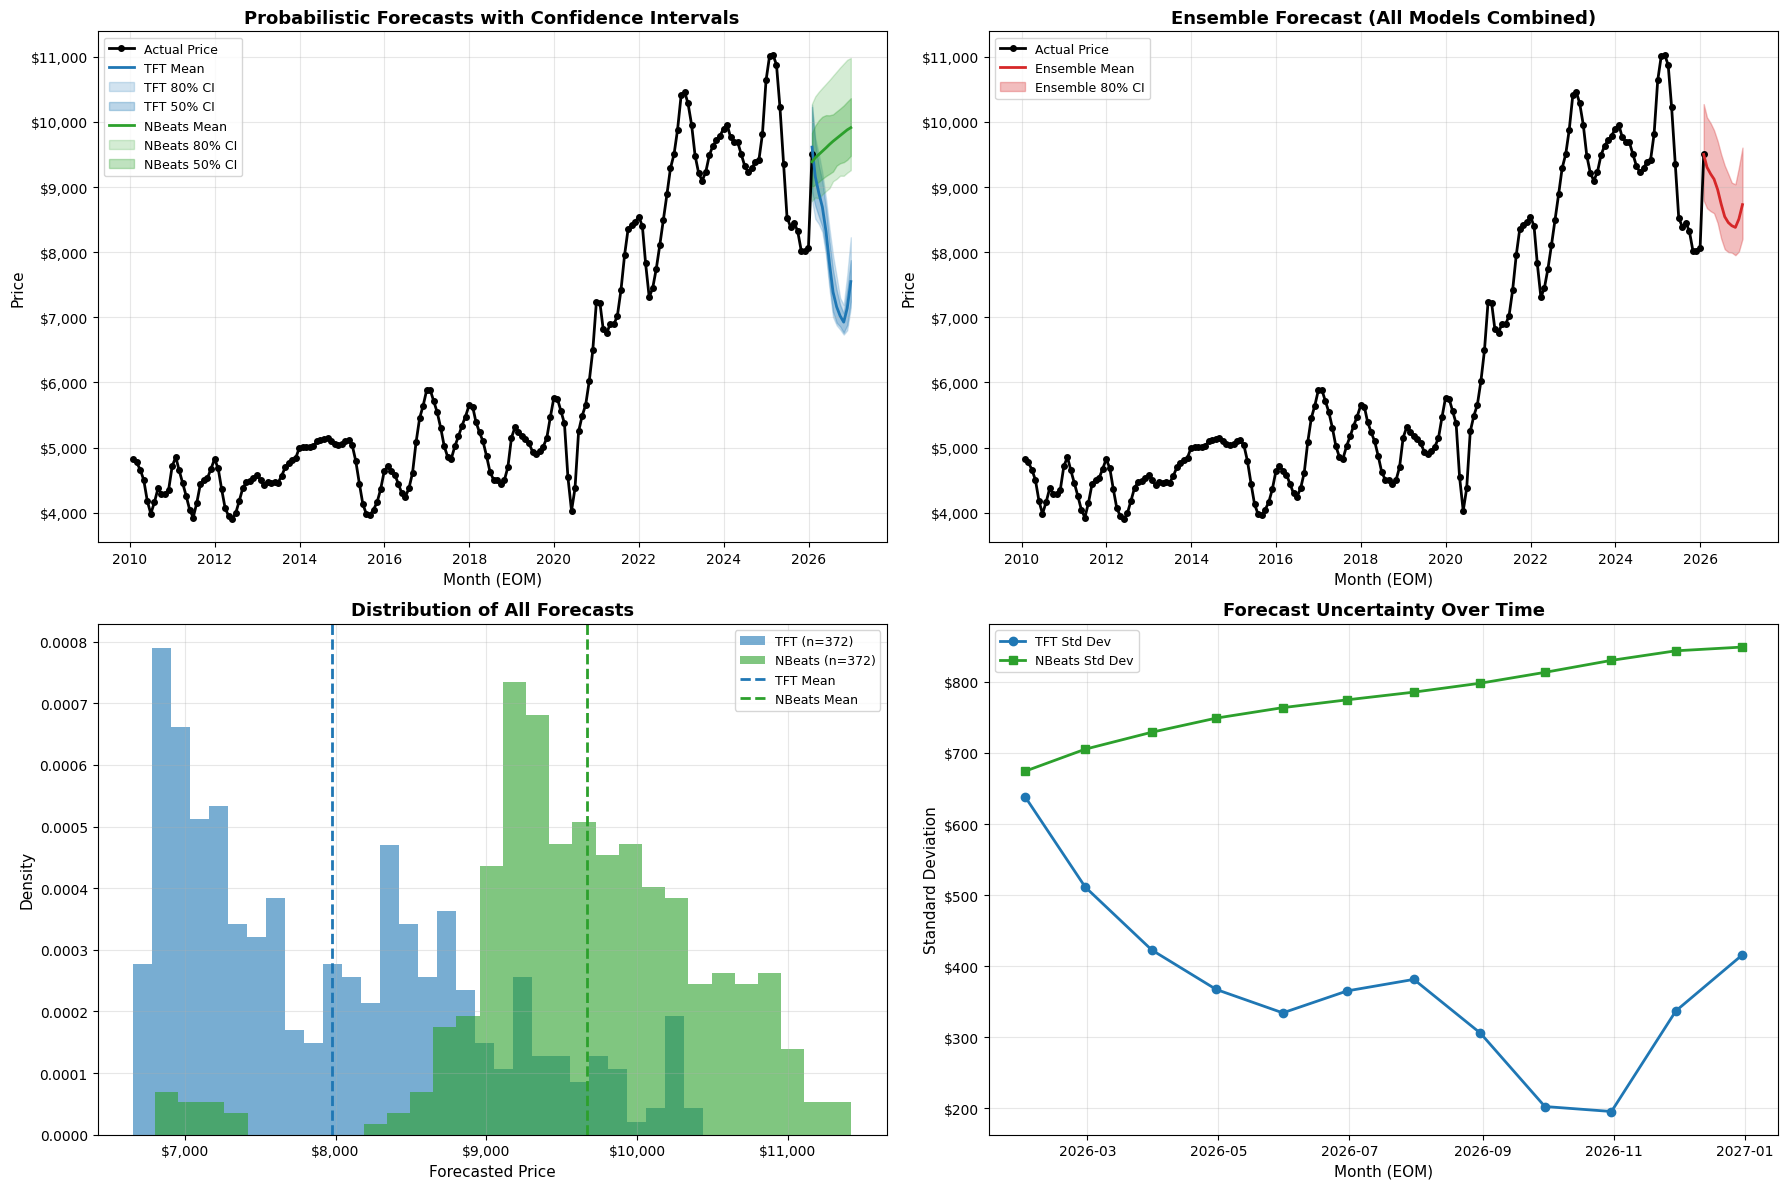


FORECAST SUMMARY STATISTICS

Total forecasts generated: 62
  - TFT forecasts: 31
  - NBeats forecasts: 31

TFT Forecast Statistics:
  Mean: $7,975.82
  Std: $972.35
  Min: $6,659.34
  Max: $10,439.71

NBeats Forecast Statistics:
  Mean: $9,667.57
  Std: $795.53
  Min: $6,800.54
  Max: $11,417.25

Ensemble Forecast (Next 12 months):
  2026-01-31: $9,500.46
  2026-02-28: $9,305.56
  2026-03-31: $9,202.90
  2026-04-30: $9,121.82
  2026-05-31: $8,962.20
  2026-06-30: $8,742.47
  2026-07-31: $8,545.30
  2026-08-31: $8,454.56
  2026-09-30: $8,406.24
  2026-10-31: $8,380.10
  2026-11-30: $8,508.57
  2026-12-31: $8,730.17



In [29]:
# Comprehensive visualization of all grid search forecasts

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from scipy import stats

# Prepare data for plotting
plot_df = combined[["eom", "price"]].set_index("eom").copy()

# Organize forecasts by model type and date
tft_forecasts = {}
nbeats_forecasts = {}

for result in all_results:
    dates = pd.to_datetime(result.dates)  # Convert string dates back to datetime
    forecast_values = np.array(result.forecast)  # Convert list back to numpy array
    
    if result.model_name == "TFT":
        for date, value in zip(dates, forecast_values):
            if date not in tft_forecasts:
                tft_forecasts[date] = []
            tft_forecasts[date].append(value)
    elif result.model_name == "NBeats":
        for date, value in zip(dates, forecast_values):
            if date not in nbeats_forecasts:
                nbeats_forecasts[date] = []
            nbeats_forecasts[date].append(value)

# Create forecast DataFrames with statistics
def create_forecast_df(forecasts_dict, model_name):
    """Create DataFrame with mean, percentiles from multiple forecasts"""
    dates = sorted(forecasts_dict.keys())
    data = {
        "eom": dates,
        f"{model_name}_mean": [],
        f"{model_name}_p10": [],
        f"{model_name}_p25": [],
        f"{model_name}_p75": [],
        f"{model_name}_p90": [],
        f"{model_name}_std": [],
    }
    
    for date in dates:
        values = np.array(forecasts_dict[date])
        data[f"{model_name}_mean"].append(np.mean(values))
        data[f"{model_name}_p10"].append(np.percentile(values, 10))
        data[f"{model_name}_p25"].append(np.percentile(values, 25))
        data[f"{model_name}_p75"].append(np.percentile(values, 75))
        data[f"{model_name}_p90"].append(np.percentile(values, 90))
        data[f"{model_name}_std"].append(np.std(values))
    
    return pd.DataFrame(data).set_index("eom")

tft_forecast_df = create_forecast_df(tft_forecasts, "TFT")
nbeats_forecast_df = create_forecast_df(nbeats_forecasts, "NBeats")

# Combine all forecasts
all_forecast_df = pd.concat([tft_forecast_df, nbeats_forecast_df], axis=1)

# Merge with actual prices
plot_df = plot_df.join(all_forecast_df, how="outer").sort_index()

# Calculate ensemble forecast (average of all models)
plot_df["ensemble_mean"] = plot_df[["TFT_mean", "NBeats_mean"]].mean(axis=1)
plot_df["ensemble_p10"] = plot_df[["TFT_p10", "NBeats_p10"]].mean(axis=1)
plot_df["ensemble_p90"] = plot_df[["TFT_p90", "NBeats_p90"]].mean(axis=1)
plot_df.iloc[len(combined.index), plot_df.columns.get_loc("price")] = plot_df.iloc[len(combined.index), plot_df.columns.get_loc("ensemble_mean")]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: All forecasts with confidence intervals
ax1 = axes[0, 0]
ax1.plot(plot_df.index, plot_df["price"], label="Actual Price", color="black", linewidth=2, marker="o", markersize=4)

# TFT forecasts with confidence intervals
if "TFT_mean" in plot_df.columns:
    ax1.plot(plot_df.index, plot_df["TFT_mean"], label="TFT Mean", color="tab:blue", linewidth=2)
    ax1.fill_between(plot_df.index, plot_df["TFT_p10"], plot_df["TFT_p90"], 
                     alpha=0.2, color="tab:blue", label="TFT 80% CI")
    ax1.fill_between(plot_df.index, plot_df["TFT_p25"], plot_df["TFT_p75"], 
                     alpha=0.3, color="tab:blue", label="TFT 50% CI")

# NBeats forecasts with confidence intervals
if "NBeats_mean" in plot_df.columns:
    ax1.plot(plot_df.index, plot_df["NBeats_mean"], label="NBeats Mean", color="tab:green", linewidth=2)
    ax1.fill_between(plot_df.index, plot_df["NBeats_p10"], plot_df["NBeats_p90"], 
                     alpha=0.2, color="tab:green", label="NBeats 80% CI")
    ax1.fill_between(plot_df.index, plot_df["NBeats_p25"], plot_df["NBeats_p75"], 
                     alpha=0.3, color="tab:green", label="NBeats 50% CI")

ax1.set_xlabel("Month (EOM)", fontsize=11)
ax1.set_ylabel("Price", fontsize=11)
ax1.set_title("Probabilistic Forecasts with Confidence Intervals", fontsize=13, fontweight="bold")
ax1.legend(loc="best", fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"${x:,.0f}"))

# Plot 2: Ensemble forecast
ax2 = axes[0, 1]
ax2.plot(plot_df.index, plot_df["price"], label="Actual Price", color="black", linewidth=2, marker="o", markersize=4)
if "ensemble_mean" in plot_df.columns:
    ax2.plot(plot_df.index, plot_df["ensemble_mean"], label="Ensemble Mean", color="tab:red", linewidth=2)
    ax2.fill_between(plot_df.index, plot_df["ensemble_p10"], plot_df["ensemble_p90"], 
                     alpha=0.3, color="tab:red", label="Ensemble 80% CI")
ax2.set_xlabel("Month (EOM)", fontsize=11)
ax2.set_ylabel("Price", fontsize=11)
ax2.set_title("Ensemble Forecast (All Models Combined)", fontsize=13, fontweight="bold")
ax2.legend(loc="best", fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"${x:,.0f}"))

# Plot 3: Forecast distribution by model
ax3 = axes[1, 0]
tft_all_forecasts = []
nbeats_all_forecasts = []

for result in all_results:
    if result.model_name == "TFT":
        tft_all_forecasts.extend(result.forecast)
    elif result.model_name == "NBeats":
        nbeats_all_forecasts.extend(result.forecast)

if tft_all_forecasts and nbeats_all_forecasts:
    ax3.hist(tft_all_forecasts, bins=30, alpha=0.6, label=f"TFT (n={len(tft_all_forecasts)})", color="tab:blue", density=True)
    ax3.hist(nbeats_all_forecasts, bins=30, alpha=0.6, label=f"NBeats (n={len(nbeats_all_forecasts)})", color="tab:green", density=True)
    ax3.axvline(np.mean(tft_all_forecasts), color="tab:blue", linestyle="--", linewidth=2, label="TFT Mean")
    ax3.axvline(np.mean(nbeats_all_forecasts), color="tab:green", linestyle="--", linewidth=2, label="NBeats Mean")
    ax3.set_xlabel("Forecasted Price", fontsize=11)
    ax3.set_ylabel("Density", fontsize=11)
    ax3.set_title("Distribution of All Forecasts", fontsize=13, fontweight="bold")
    ax3.legend(loc="best", fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"${x:,.0f}"))

# Plot 4: Forecast uncertainty over time
ax4 = axes[1, 1]
if "TFT_std" in plot_df.columns and "NBeats_std" in plot_df.columns:
    ax4.plot(plot_df.index, plot_df["TFT_std"], label="TFT Std Dev", color="tab:blue", linewidth=2, marker="o")
    ax4.plot(plot_df.index, plot_df["NBeats_std"], label="NBeats Std Dev", color="tab:green", linewidth=2, marker="s")
    ax4.set_xlabel("Month (EOM)", fontsize=11)
    ax4.set_ylabel("Standard Deviation", fontsize=11)
    ax4.set_title("Forecast Uncertainty Over Time", fontsize=13, fontweight="bold")
    ax4.legend(loc="best", fontsize=9)
    ax4.grid(True, alpha=0.3)
    ax4.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"${x:,.0f}"))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("FORECAST SUMMARY STATISTICS")
print("="*60)
print(f"\nTotal forecasts generated: {len(all_results)}")
print(f"  - TFT forecasts: {sum(1 for r in all_results if r.model_name == 'TFT')}")
print(f"  - NBeats forecasts: {sum(1 for r in all_results if r.model_name == 'NBeats')}")

if tft_all_forecasts:
    print(f"\nTFT Forecast Statistics:")
    print(f"  Mean: ${np.mean(tft_all_forecasts):,.2f}")
    print(f"  Std: ${np.std(tft_all_forecasts):,.2f}")
    print(f"  Min: ${np.min(tft_all_forecasts):,.2f}")
    print(f"  Max: ${np.max(tft_all_forecasts):,.2f}")

if nbeats_all_forecasts:
    print(f"\nNBeats Forecast Statistics:")
    print(f"  Mean: ${np.mean(nbeats_all_forecasts):,.2f}")
    print(f"  Std: ${np.std(nbeats_all_forecasts):,.2f}")
    print(f"  Min: ${np.min(nbeats_all_forecasts):,.2f}")
    print(f"  Max: ${np.max(nbeats_all_forecasts):,.2f}")

if "ensemble_mean" in plot_df.columns:
    print(f"\nEnsemble Forecast (Next 12 months):")
    ensemble_forecast = plot_df["ensemble_mean"].dropna()
    for date, value in ensemble_forecast.items():
        print(f"  {date.strftime('%Y-%m-%d')}: ${value:,.2f}")

print("\n" + "="*60)
